In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#%matplotlib notebook
%matplotlib inline

In [3]:
# delta robot param
# https://www.researchgate.net/publication/272747262_DEVELOPMENT_OF_A_PARALLEL_ROBOT_DELTA_KEOPS_WITH_MODIFIED_STRUCTURE

Rb = 1.0    # base radius
Rm = 0.2    # mobile platfrom radius

Lr = 1.2    # prismatic joint length
Le = 1.2    # link lengt

alpha = np.pi/4  # 45° = π/4

In [4]:
# rot matrix in z (120° = 2π/3)
rot_z_120 = np.array([
    [np.cos(2*np.pi/3),   -np.sin(2*np.pi/3), 0],
    [np.sin(2*np.pi/3),    np.cos(2*np.pi/3), 0],
    [0,                     0,                1]
])

In [5]:
def forward(joints):
    
    # calc sphere centers
    h = np.zeros(3)
    for i in range(3):
        h[i] = np.sin(alpha)*joints[i]

    C1 = np.array([Rb-Rm-h[0], 0, -h[0]])
    C2 = np.array(np.dot(rot_z_120, [Rb-Rm-h[1], 0, -h[1]]))
    C3 = np.array(np.dot(rot_z_120.T, [Rb-Rm-h[2], 0, -h[2]]))


    # do the "three spheres intersections" approach.
    # awesome stuff here: https://gist.github.com/ahcurrier/1a03faa8b0c2420ec6fd
    k1 = - C1[0]**2 + C2[0]**2 - C1[1]**2 + C2[1]**2 - C1[2]**2 + C2[2]**2
    k3 = - C3[0]**2 + C2[0]**2 - C3[1]**2 + C2[1]**2 - C3[2]**2 + C2[2]**2
    
    a1 = 2 * (C2[0] - C1[0])
    b1 = 2 * (C2[1] - C1[1])
    c1 = 2 * (C2[2] - C1[2])
    
    a3 = 2 * (C2[0] - C3[0])
    b3 = 2 * (C2[1] - C3[1])
    c3 = 2 * (C2[2] - C3[2])
    
    if a1 == 0:
        e, f = -c1 / b1, k1 / b1
    elif a3 == 0:
        e, f = -c3 / b3, k3 / b3
    else:
        a31 = a3 / a1
        e, f = -((a31 * c1 - c3) / (a31 * b1 - b3)), (a31 * k1 - k3) / (a31 * b1 - b3)
    
    b31 = b3 / b1
    g, h = -((b31 * c1 - c3) / (b31 * a1 - a3)), (b31 * k1 - k3) / (b31 * a1 - a3)
    
    A = g**2 + e**2 + 1
    B = -C1[0] * g - C1[1] * e - 2 * C1[2] - C1[0] * g - C1[1] * e + 2 * g * h + 2 * e * f
    C = C1[0]**2 + C1[1]**2 + C1[2]**2 - 2 * C1[0] * h - 2 * C1[1] * f + h**2 + f**2 - Le**2
    
    # Quadratic formula: z = (-B +- sqrt(B^2 - 4AC)) / 2A
    root = B**2 - 4 * A * C
    z = (-B - np.sqrt(root)) / (2 * A)
    
    # Calculate corresponding x and y values
    x = g * z + h
    y = e * z + f
    
    return np.array([x, y, z,])

inverse kinematic:\
$\vec{p} = [x\ y\ z]^T$\
\
$\alpha = 45° = \frac{pi}{4} rad$\
\
$R = \begin{bmatrix}1&0&0\\0&1&0\\0&0&1\end{bmatrix}$\
\
$R_{z120} = \begin{bmatrix}cos(\frac{2\pi}{3})& -sin(\frac{2\pi}{3})&0\\ sin(\frac{2\pi}{3})& cos(\frac{2\pi}{3})&0\\0&0&1\end{bmatrix}$\
\
$\vec{b_1} = [R_m\ 0\ 0]^T$\
$\vec{b_2} = R_{z120}*\vec{b_1}$\
$\vec{b_3} = R_{z120}^T*\vec{b_1}$\
\
$q_i = p + R * \vec{b_i}$\
\
$\vec{a_1} = [R_b\ 0\ 0]^T$\
$\vec{a_2} = R_{z120}*\vec{a_1}$\
$\vec{a_3} = R_{z120}^T*\vec{a_1}$\
\
$\vec{L_i} = \vec{q_i} - \vec{a_i}$\
\
$\vec{d0_1} = [-cos(\alpha)\ 0\ -sin(\alpha)]^T$\
$\vec{d0_2} = R_{z120}*\vec{d0_1}$\
$\vec{d0_3} = R_{z120}^T*\vec{d0_1}$\
\
$d_i = (\vec{L_i}*\vec{d0_i}) \pm \sqrt{(\vec{L_i}*\vec{d0_i})^2 -|L_i|^2 + L_e ^2}$
 


In [6]:
def draw(pos, draw_tcp_cart=False, inverse=False):
    
    plt.figure(figsize=(10,10))
    axlim = [-1.5, 1.5]
    ax = plt.axes(projection='3d')

    # ---- BASE ------
    # base corners top
    A1 = np.array([Rb, 0, 0])
    A2 = np.dot(rot_z_120, A1)
    A3 = np.dot(rot_z_120.T, A1)

    # draw base 
    ax.plot([A1[0], A2[0]], [A1[1], A2[1]], [A1[2], A2[2]], color="black", linewidth=2)
    ax.plot([A2[0], A3[0]], [A2[1], A3[1]], [A2[2], A3[2]], color="black", linewidth=2)
    ax.plot([A3[0], A1[0]], [A3[1], A1[1]], [A3[2], A1[2]], color="black", linewidth=2)

    # check axis length
    h = np.cos(alpha)*Lr 
    r = Rb - h

    # base corners bottom
    A1_d_max = np.array([r, 0, -h])
    A2_d_max = np.dot(rot_z_120, A1_d_max)
    A3_d_max = np.dot(rot_z_120.T, A1_d_max)
    
    # draw base circle
    t = np.linspace(0, 2*np.pi)
    ax.plot(np.sin(t)*r, np.cos(t)*r, -h, color="black", linewidth=2)
    
    # ---- ARMS ------
    # draw linear axis
    ax.plot([A1[0],A1_d_max[0]], [A1[1],A1_d_max[1]], [A1[2],A1_d_max[2]], color="black", linewidth=2)
    ax.plot([A2[0],A2_d_max[0]], [A2[1],A2_d_max[1]], [A2[2],A2_d_max[2]], color="black", linewidth=2)
    ax.plot([A3[0],A3_d_max[0]], [A3[1],A3_d_max[1]], [A3[2],A3_d_max[2]], color="black", linewidth=2)

    # inverse
    a = []
    a.append(np.array([Rb, 0, 0]))
    a.append(np.dot(rot_z_120, a[0]))
    a.append(np.dot(rot_z_120.T, a[0]))

    b = []
    b.append(np.array([Rm, 0, 0]))
    b.append(np.dot(rot_z_120, b[0]))
    b.append(np.dot(rot_z_120.T, b[0]))

    R = np.eye(3)
   
    q = []
    q.append(pos + np.matmul(R, b[0]))
    q.append(pos + np.matmul(R, b[1]))
    q.append(pos + np.matmul(R, b[2]))

    L = []
    L.append(q[0] - a[0])
    L.append(q[1] - a[1])
    L.append(q[2] - a[2])

    d0 = []
    d0.append(np.array([-np.cos(alpha), 0, -np.sin(alpha)]))
    d0.append(np.dot(rot_z_120, d0[0]))
    d0.append(np.dot(rot_z_120.T, d0[0]))

    d = np.zeros(3)
    h = np.zeros(3)
    
    for i in range(3):
        root = np.dot(L[i], d0[i])**2  - np.linalg.norm(L[i])**2 + Le**2
        if root < 0: raise Exception("Position not reachable!")
        d[i] = (np.dot(L[i], d0[i]) - np.sqrt(root))
        if not 0 <= d[i] <= Lr: raise Exception("Axis cannot move to this position!")
        h[i] = np.sin(alpha)*d[i]
    
    if inverse: print(f"Inverse Joints: {d.round(4)}")

    D1 = np.array([Rb-h[0], 0, -h[0]])
    D2 = np.array(np.dot(rot_z_120, [Rb-h[1], 0, -h[1]]))
    D3 = np.array(np.dot(rot_z_120.T, [Rb-h[2], 0, -h[2]]))

    # draw axis joints
    ax.scatter(D1[0], D1[1], D1[2], color="black")
    ax.scatter(D2[0], D2[1], D2[2], color="black")
    ax.scatter(D3[0], D3[1], D3[2], color="black")

    # draw arm
    ax.plot([D1[0], q[0][0]], [D1[1], q[0][1]], [D1[2], q[0][2]], color="black", linewidth=2)
    ax.plot([D2[0], q[1][0]], [D2[1], q[1][1]], [D2[2], q[1][2]], color="black", linewidth=2)
    ax.plot([D3[0], q[2][0]], [D3[1], q[2][1]], [D3[2], q[2][2]], color="black", linewidth=2)

    # ---- PLATFORM ------
    # draw platfrom center
    ax.scatter(q[0][0]-Rm, q[0][1], q[0][2], color="red")

    # draw platfrom
    ax.plot([q[0][0], q[1][0]], [q[0][1], q[1][1]], [q[0][2], q[1][2]], color="black", linewidth=2)
    ax.plot([q[1][0], q[2][0]], [q[1][1], q[2][1]], [q[1][2], q[2][2]], color="black", linewidth=2)
    ax.plot([q[2][0], q[0][0]], [q[2][1], q[0][1]], [q[2][2], q[0][2]], color="black", linewidth=2)

    # draw platfrom joints
    ax.scatter(q[0][0], q[0][1], q[0][2], color="black")
    ax.scatter(q[1][0], q[1][1], q[1][2], color="black")
    ax.scatter(q[2][0], q[2][1], q[2][2], color="black")

    # draw tcp cart
    if draw_tcp_cart:
        length = 0.4
        ax.plot([pos[0],pos[0]+length], [pos[1],pos[1]], [pos[2],pos[2]], color="red", linewidth=1)
        ax.plot([pos[0],pos[0]], [pos[1],pos[1]+length], [pos[2],pos[2]], color="green", linewidth=1)
        ax.plot([pos[0],pos[0]], [pos[1],pos[1]], [pos[2],pos[2]+length], color="blue", linewidth=1)

    ax.set_box_aspect(aspect=(1, 1, 0.5), zoom=0.90)
    ax.set_xlim(axlim)
    ax.set_xlabel('$X$', fontsize=14)
    ax.set_ylim(axlim)
    ax.set_ylabel('$Y$', fontsize=14)
    ax.set_zlim(axlim[0], 0)
    ax.set_zlabel('$Z$', fontsize=14)
    
    #ax.invert_zaxis()
    #ax.view_init(elev=0, azim=90, roll=0)

    return plt

In [7]:
def draw_forward(joints, draw_tcp_cart=False):
    print(f"Forward Pos: {forward(joints).round(4)}")
    return draw(forward(joints), draw_tcp_cart)

def draw_inverse(tcp, draw_tcp_cart=False):
    return draw(tcp, draw_tcp_cart, True)

Inverse Joints: [0.5 0.5 0.5]


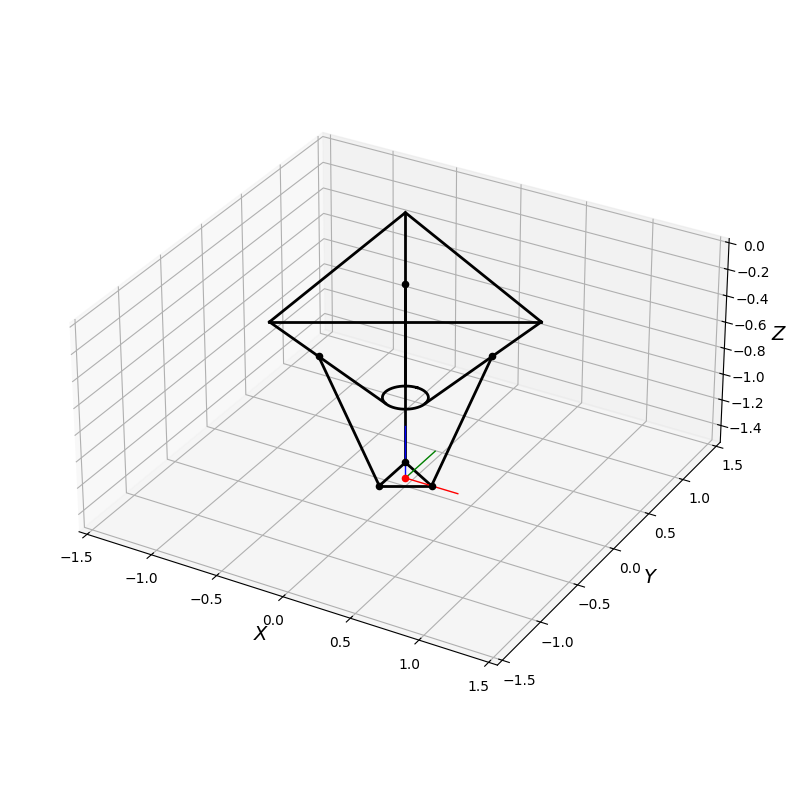

In [8]:
joints = np.array([.5, .5, .5])
pos = forward(joints)
draw_inverse(pos, draw_tcp_cart=True).show()

<img src="images/keops_x-axis.gif" alt="drawing" width="600"/>
<img src="images/keops_y-axis.gif" alt="drawing" width="600"/>
<br>
<img src="images/keops_z-axis.gif" alt="drawing" width="600"/>
<img src="images/keops_circle.gif" alt="drawing" width="600"/>